In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import time

from pycsou.linop.conv import Convolve2D
from pycsou.func.loss import SquaredL2Loss
from pycsou.func.penalty import SquaredL2Norm, L2Norm, L1Norm, NonNegativeOrthant
from pycsou.opt.proxalgs import APGD, PDS
from pycsou.linop.diff import Gradient

from scripts.functionals import DCT2, HuberNorm, OptiConvolve2D

d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:945: SyntaxWarning: "is" with a literal. Did you mean "=="?
d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:965: SyntaxWarning: "is" with a literal. Did you mean "=="?
d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:969: SyntaxWarning: "is" with a literal. Did you mean "=="?
d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:945: SyntaxWarning: "is" with a literal. Did you mean "=="?
d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\linop\sampling.py:965: SyntaxWarni

### Comparing Old and new Convolve2D Method in precision

[179 319]
(slice(44, 134, None), slice(79, 239, None), slice(0, 3, None))
(slice(45, 135, None), slice(80, 240, None), slice(0, 3, None))
Custom2D vs Convolve2D conv norm difference:  1.9278971571353883e-10
Custom2D vs Convolve2D conv mean difference:  7.352933077224103e-13
Custom2D vs Convolve2D corr norm difference:  1.7379438179261358e-10
Custom2D vs Convolve2D corr mean difference:  6.557493642739481e-13


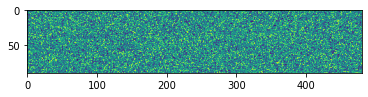

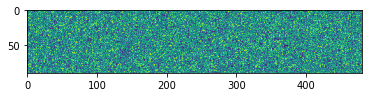

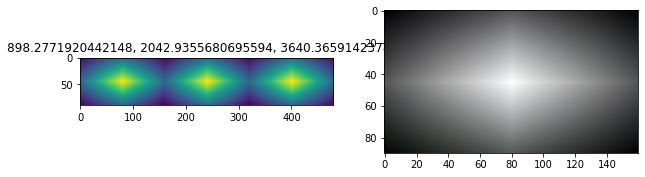

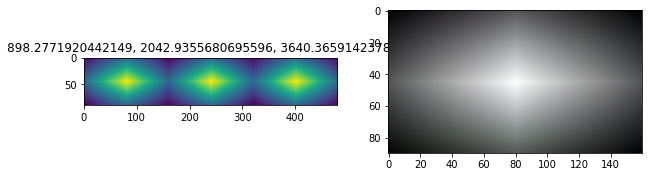

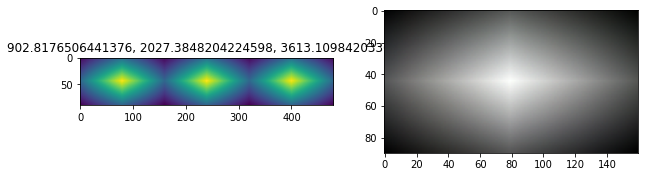

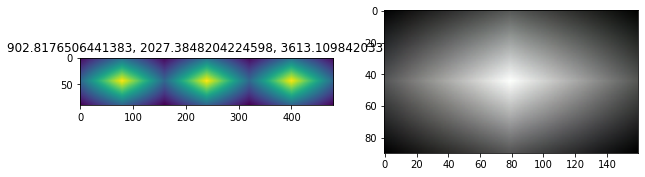

In [3]:
# ===========================================================================
# Custom Parameters: 
# - shape can be any size and channel number can be 1, 3, 4
# - dtype can be np.float32 or np.float64 if you want to see the impact on 
#   the precision with the original technique
    
shape = (90, 160, 3)
dtype = np.float64

# =====================================================================

shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
x = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def conc_channels(v):
    return np.concatenate([v[:,:,i] for i in range(v.shape[2])], axis=1)

plt.figure()
plt.imshow(conc_channels(x))
plt.figure()
plt.imshow(conc_channels(psf))

H = OptiConvolve2D(psf)
print(H.fshape2d)
print(H.fslice2d_conv)
print(H.fslice2d_corr)
Hops = [Convolve2D(size=y.size/shape[2], filter=psf[:,:,i], shape=shape2d, method='fft') for i in range(shape[2])]

conv2d_conv = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_conv[:,:,i] = Hops[i](x[:,:,i].flatten()).reshape(*shape2d)
custom2d_conv = H(x.flatten()).reshape(*shape)

conv2d_corr = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_corr[:,:,i] = Hops[i].adjoint(y[:,:,i].flatten()).reshape(*shape2d)
custom2d_corr = H.adjoint(y.flatten()).reshape(*shape)

print("Custom2D vs Convolve2D conv norm difference: ", np.linalg.norm(conv2d_conv - custom2d_conv))
print("Custom2D vs Convolve2D conv mean difference: ", np.mean(np.abs(conv2d_conv - custom2d_conv)))
print("Custom2D vs Convolve2D corr norm difference: ", np.linalg.norm(conv2d_corr - custom2d_corr))
print("Custom2D vs Convolve2D corr mean difference: ", np.mean(np.abs(conv2d_corr - custom2d_corr)))
    
for t in [conv2d_conv, custom2d_conv, conv2d_corr, custom2d_corr]:
    fig, axs = plt.subplots(1,2, figsize=(10,10))
    axs[0].imshow(conc_channels(t))
    axs[0].set_title(f"{t.min()}, {t.mean()}, {t.max()}")
    t = (t - t.min())/(t.max() - t.min())
    axs[1].imshow(t)


### Comparing old and new Convolve2D method for Inverse Problem

d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\core\functional.py:152: UserWarning: For differentiable and/or linear maps, consider the dedicated classes DifferentiableMap and LinearOperator.


Custom2D time: 1.6946911811828613
Custom2D time: 1.0674176216125488
Custom2D time: 1.0672848224639893
Custom2D time: 0.8587648868560791
Custom2D time: 0.8518280982971191
Custom2D time: 0.8766541481018066
Custom2D time: 1.0227735042572021
Custom2D time: 1.4916760921478271
Custom2D time: 1.1040456295013428
Custom2D time: 0.9514551162719727
Convolve2D time: 0.4138915538787842
Convolve2D time: 0.3206624984741211
Convolve2D time: 0.37499570846557617
Convolve2D time: 0.5222077369689941
Convolve2D time: 0.5195019245147705
Convolve2D time: 0.5172452926635742
Convolve2D time: 0.6382913589477539
Convolve2D time: 0.3899562358856201
Convolve2D time: 0.31615638732910156
Convolve2D time: 0.3091714382171631


Text(0.5, 1.0, 'Custom2D difference between measurement and Forward')

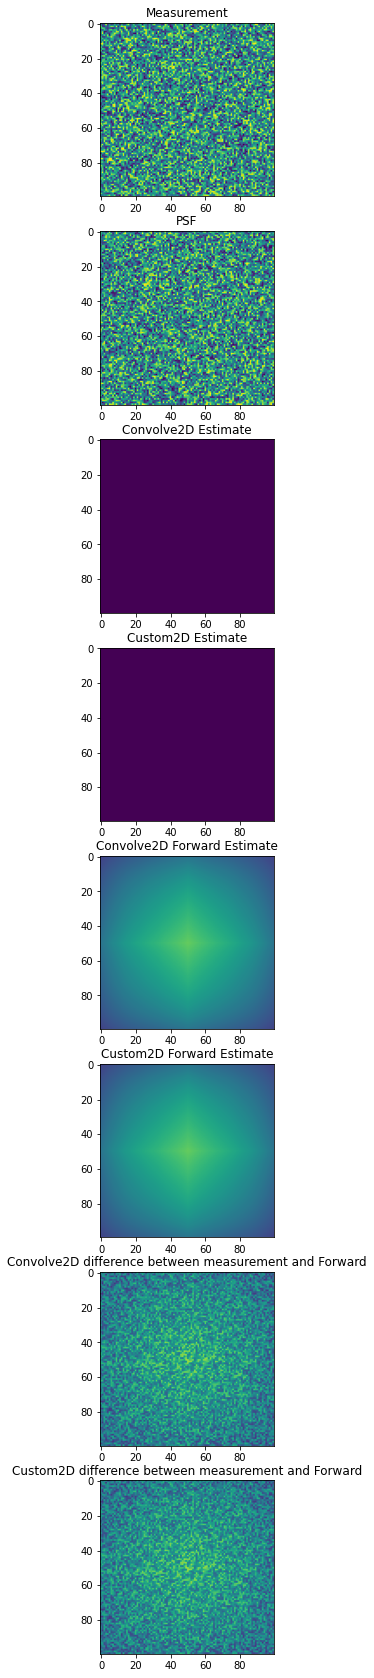

In [12]:
shape = (100, 100, 1)
dtype = np.float64


shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def custom2d(y, psf, niter=10):
    Hop = OptiConvolve2D(psf)
    Hop.compute_lipschitz_cst(tol=5e-1)
    lambda_ = 0.1
    l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y.flatten())
    F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

    apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                min_iter=1, max_iter=niter, accuracy_threshold=0.0001)

    estimate, _, _ = apgd.iterate()
    estimate = estimate['iterand'].reshape(y.shape)
    return estimate, Hop(estimate.flatten()).reshape(y.shape)
    
def conv2d(y, psf, niter=10):
    complete_estimate = np.zeros_like(y)
    complete_foresti = np.zeros_like(y)
    for i in range(y.shape[2]):
        yi_shape = y[:,:,i].shape
        Hop = Convolve2D(size=y[:,:,i].size, filter=psf[:,:,i], shape=yi_shape, method='fft')
        Hop.compute_lipschitz_cst(tol=5e-1)
        lambda_ = 0.1
        l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y[:,:,i].flatten())
        F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

        apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                    min_iter=1, max_iter=niter, accuracy_threshold=0.0001)

        estimate, _, _ = apgd.iterate()
        estimate = estimate['iterand'].reshape(yi_shape)
        complete_estimate[:,:,i] = estimate
        complete_foresti[:,:,i] = Hop(estimate.flatten()).reshape(yi_shape)
    return complete_estimate, complete_foresti

for _ in range(10):
    start_time = time.time()    
    custom2d_esti, custom2d_foresti = custom2d(y, psf)
    custom2d_elapsed = time.time() - start_time
    print("Custom2D time:", custom2d_elapsed)

for _ in range(10):
    start_time = time.time()
    conv2d_esti, conv2d_foresti = conv2d(y, psf)
    conv2d_elapsed = time.time() - start_time
    print("Convolve2D time:", conv2d_elapsed)

_, axs = plt.subplots(8, 1, figsize=(10, 30))
axs[0].imshow(y, vmin=0, vmax=1)
axs[0].set_title("Measurement")
axs[1].imshow(psf, vmin=0, vmax=1)
axs[1].set_title("PSF")
axs[2].imshow(conv2d_esti, vmin=0, vmax=1)
axs[2].set_title("Convolve2D Estimate")
axs[3].imshow(custom2d_esti, vmin=0, vmax=1)
axs[3].set_title("Custom2D Estimate")
axs[4].imshow(conv2d_foresti, vmin=0, vmax=1)
axs[4].set_title("Convolve2D Forward Estimate")
axs[5].imshow(custom2d_foresti, vmin=0, vmax=1)
axs[5].set_title("Custom2D Forward Estimate")
axs[6].imshow(conv2d_foresti - y, vmin=-1, vmax=1)
axs[6].set_title("Convolve2D difference between measurement and Forward")
axs[7].imshow(custom2d_foresti - y, vmin=-1, vmax=1)
axs[7].set_title("Custom2D difference between measurement and Forward")
